In [312]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
from scipy.stats import ttest_ind, linregress
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])


csv["contrat_fini"] = (csv["sortie"] != max(csv["sortie"]))
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1


#Vire les problèmes liés aux ministres
csv = csv[csv["nombredejours"] > 7]
#Vire les contrats courts de début de législature : sans doute la fin d'un contrat de la législature précédente
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]
csv.drop("collaborateurs", 1, inplace=True)

In [328]:
csv[csv["parlementaire"] == "Christine Hennion"]
#csv#.columns

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,nb_mandats,entree,sortie,nombredejours,contrat_fini,duree_mandat,parlementaire_age,contrat_plus_de_2_mois,contrat_plus_de_4_mois,contrat_plus_de_6_mois
847,Christine Hennion,Hennion,Christine,F,M. Mickaël Philippe,Philippe,Mickaël,H,https://www.nosdeputes.fr/christine-hennion/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-11-08 02:15:20,2018-01-09 02:15:24,62.0,True,373,62,1,0,0
870,Christine Hennion,Hennion,Christine,F,M. Sélim Denoyelle,Sélim,Denoyelle,H,https://www.nosdeputes.fr/christine-hennion/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-07-28 01:15:29,2018-06-02 01:15:49,309.0,True,373,62,1,1,1
1903,Christine Hennion,Hennion,Christine,F,Mme Flavienne Elom,Elom,Flavienne,F,https://www.nosdeputes.fr/christine-hennion/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-11-15 02:15:28,2018-06-28 22:00:00,225.0,False,373,62,1,1,1
2071,Christine Hennion,Hennion,Christine,F,Mme Fanny Morisset,Morisset,Fanny,F,https://www.nosdeputes.fr/christine-hennion/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-11-08 02:15:20,2017-12-23 02:15:24,45.0,True,373,62,0,0,0
2676,Christine Hennion,Hennion,Christine,F,M. Valentin Mugnié,Mugnié,Valentin,H,https://www.nosdeputes.fr/christine-hennion/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,2017-09-05 01:15:23,2018-06-28 22:00:00,296.0,False,373,62,1,1,1


## Le nombre de collaborateurs 

In [275]:
csv.count()['collaborateur']

2719

## Description générale sur le comportement des députés


In [304]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")
duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

Des députés ont des collaborateurs fidèles.

Ces fidèles sont représentés par le palier supérieur à droite du graph suivant : la durée de leur contrat est égale à la durée de la législature.

Hypothèses pour le second palier à 300 jours : ce sont les fidèles des parlementaires suppléants de ministre du gouvernement Philippe 1.

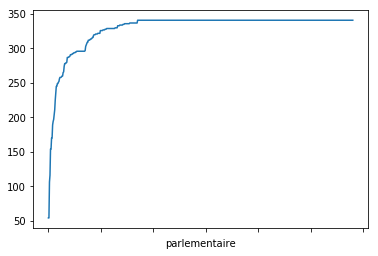

In [284]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Tri par la durée du contrat le plus court de chaque parlementaire

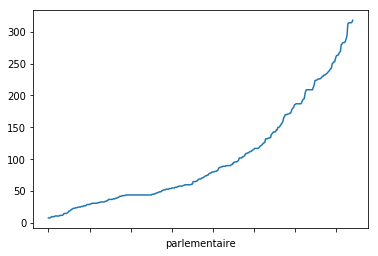

In [285]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

## Les députés et le turnover de leurs collaborateurs

Tri par le contrat max pour faire remonter les parlementaires qui gardent peu de collaborateurs sur le long terme : 
**ils n'ont pas de fidèles**

In [314]:
#On retire les députés nouvellement élus
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('contrat_max').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "ratio_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)


,parlementaire,groupe_sigle,sexe_parlementaire,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,nb_contrat_fini,ratio_contrat_fini
300,José Evrard,NI,H,100.0,101.428571,7,154.0,7.0,1.000000
22,Anissa Khedher,LREM,F,68.0,92.000000,7,170.0,5.0,0.714286
328,Loïc Dombreval,LREM,H,163.0,161.750000,4,189.0,2.0,0.500000
346,Marie Lebec,LREM,F,187.5,185.750000,4,197.0,1.0,0.250000
539,Valérie Petit,LREM,F,132.0,129.714286,7,204.0,4.0,0.571429
481,Sandra Marsaud,LREM,F,99.0,113.500000,6,211.0,3.0,0.500000
171,Florence Lasserre-David,MODEM,F,57.0,112.400000,5,225.0,3.0,0.600000
377,Michel Vialay,LR,H,139.5,155.000000,4,236.0,2.0,0.500000
526,Thierry Solère,LREM,H,141.5,152.333333,6,245.0,4.0,0.666667
308,Jérôme Nury,LR,H,113.0,120.714286,7,249.0,3.0,0.428571


Tri croissant par % de contrats de plus de 6 mois : fait remonter les députés ayant des fidèles mais cumulant de nombreux contrats de mois de 6 mois 

In [319]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_plus_de_6_mois').drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,ratio_contrat_fini
291,Jean-Yves Bony,LR,H,192.5,192.500000,4,341.0,0.500000,2.0,0.500000
314,Laurence Maillart-Méhaignerie,LREM,F,79.5,113.875000,8,341.0,0.500000,5.0,0.625000
434,Patrick Vignal,LREM,H,123.0,146.500000,8,341.0,0.500000,4.0,0.500000
530,Typhanie Degois,LREM,F,199.0,186.500000,4,336.0,0.500000,2.0,0.500000
221,Hervé Pellois,LREM,H,128.0,164.250000,4,341.0,0.500000,2.0,0.500000
14,Alexandre Freschi,LREM,H,119.0,144.333333,6,341.0,0.500000,4.0,0.666667
131,Danielle Brulebois,LREM,F,90.0,97.555556,9,294.0,0.555556,6.0,0.666667
316,Laurence Vanceunebrock-Mialon,LREM,F,87.0,136.000000,7,341.0,0.571429,4.0,0.571429
111,Claire Pitollat,LREM,F,148.0,143.571429,7,296.0,0.571429,4.0,0.571429
22,Anissa Khedher,LREM,F,68.0,92.000000,7,170.0,0.571429,5.0,0.714286


In [329]:
duree_collaborateurs[duree_collaborateurs["ratio_contrat_mandat"] < 0.7].sort_values('ratio_contrat_fini', ascending=False).drop(["duree_mandat", "contrat_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "ratio_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "contrat_fini_max", "contrat_fini_min", "ancien_depute", "ratio_contrat_mandat","nb_mandats","parlementaire_age"], 1).head(15)

,parlementaire,groupe_sigle,sexe_parlementaire,contrat_mediane,contrat_moyenne,nb_collaborateurs,contrat_max,ratio_plus_de_6_mois,nb_contrat_fini,ratio_contrat_fini
300,José Evrard,NI,H,100.0,101.428571,7,154.0,0.571429,7.0,1.000000
22,Anissa Khedher,LREM,F,68.0,92.000000,7,170.0,0.571429,5.0,0.714286
526,Thierry Solère,LREM,H,141.5,152.333333,6,245.0,0.666667,4.0,0.666667
191,Frédérique Lardet,LREM,F,122.5,148.333333,6,341.0,0.666667,4.0,0.666667
173,Florian Bachelier,LREM,H,142.0,157.111111,9,296.0,0.888889,6.0,0.666667
113,Claude de Ganay,LR,H,189.5,214.833333,6,341.0,0.833333,4.0,0.666667
131,Danielle Brulebois,LREM,F,90.0,97.555556,9,294.0,0.555556,6.0,0.666667
14,Alexandre Freschi,LREM,H,119.0,144.333333,6,341.0,0.500000,4.0,0.666667
489,Sira Sylla,LREM,F,151.0,141.333333,9,320.0,0.666667,6.0,0.666667
122,Cédric Roussel,LREM,H,109.5,135.250000,8,296.0,0.625000,5.0,0.625000


Plus de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois.

(La période d'essai d'un CDI de collaborateur est de 2 ou 4 mois)

In [330]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 120]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

44.234079173838211

## Par groupe politique

Les durées médianes de contrat par groupe politique.

In [331]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,213.225000
MODEM,246.510638
LREM,248.949045
LR,266.107843
GDR,269.029412
UAI,276.106061
LFI,279.705882
NG,286.032258


# Par sexe

Les durées médianes de contrat par parlementaire pour les collaborateurs femmes et hommes.


In [337]:
collab_femme_vs_homme = duree_moy_sexe = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median()
collab_femme_vs_homme

,nombredejours
sexe_collaborateur,
F,272.0
H,260.0


In [338]:
depute_femme_vs_homme = duree_moy_sexe = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median()
depute_femme_vs_homme

,nombredejours
sexe_parlementaire,
F,244.0
H,280.0


In [372]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])


In [375]:
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean()

nombredejours
sexe_parlementaire sexe_collaborateur               
F                  F                      238.228119
                   H                      222.753935
H                  F                      251.489104
                   H                      246.605020

In [378]:
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()

nb_collaborateurs
sexe_parlementaire sexe_collaborateur                   
F                  F                            2.439815
                   H                            2.620370
H                  F                            2.453731
                   H                            2.421687

# Test statistiques sur les parlementaires

In [379]:
duree_tt = duree_collaborateurs#.drop(["contrat_fini_max", "contrat_fini_min"], 1)
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1
duree_tt.fillna(150, inplace=True)


## T-Test : test de significativité des différentes variables dichotomiques.

Pour chacune des variables booléennes décrivant les parlementaires, on effectue un test qui nous indique son effet sur la durée moyenne de ses contrats.

In [383]:
for i in duree_tt.drop(["contrat_moyenne", "nb_collaborateurs", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

nb_contrat_fini : -12.412872, 0.000000

ratio_contrat_fini : -6.086752, 0.000000

ancien_depute : -2.212596, 0.027315

parlementaire_femme : -3.688165, 0.000247

parlementaire_homme : 3.688165, 0.000247

parlementaire_has_autre_mandats non significatif

groupe_LR non significatif

groupe_LREM : -1.817466, 0.069663

groupe_MODEM non significatif

groupe_NG : 1.844177, 0.065668

groupe_LFI non significatif

groupe_UAI non significatif

groupe_NI : -2.261049, 0.024126

groupe_GDR non significatif



### Tests de régression sur les variables continues

Pour chacune des variables continues, telles que l'âge ou le nombre de collaborateurs, décrivant les parlementaires, on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

nb_collaborateurs : slope:-0.016125, intercept:8.569973, 
	rvalue:-0.614718, pvalue:0.000000, stderr:0.000000



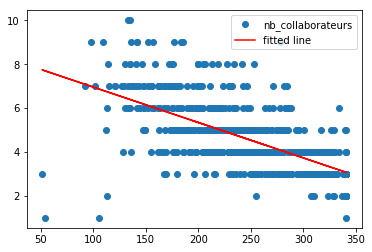

contrat_max : slope:0.250179, intercept:268.030635, 
	rvalue:0.445935, pvalue:0.000000, stderr:0.000000



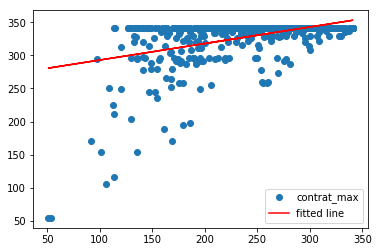

contrat_min : slope:1.447965, intercept:-220.156708, 
	rvalue:0.827904, pvalue:0.000000, stderr:0.000000



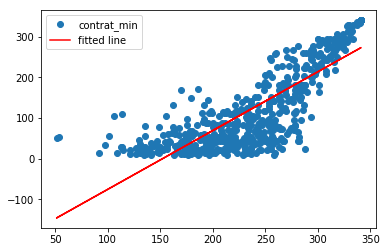

nb_contrats_plus_de_2_mois : slope:-0.013789, intercept:7.880805, 
	rvalue:-0.559270, pvalue:0.000000, stderr:0.000000



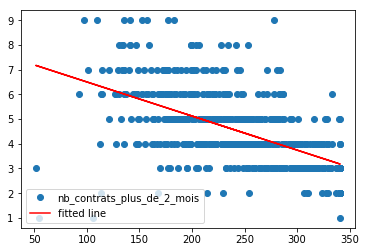

nb_contrats_plus_de_4_mois : slope:-0.008858, intercept:6.374447, 
	rvalue:-0.408669, pvalue:0.000000, stderr:0.000000



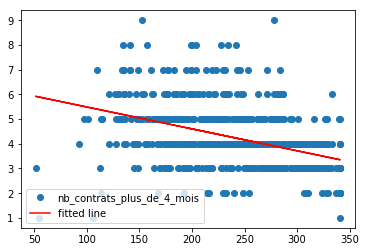

nb_contrats_plus_de_6_mois : slope:-0.006528, intercept:5.643834, 
	rvalue:-0.323261, pvalue:0.000000, stderr:0.000000



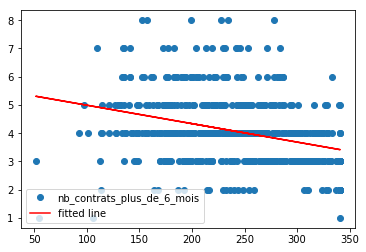

nb_contrat_fini : slope:-0.015529, intercept:4.923626, 
	rvalue:-0.751205, pvalue:0.000000, stderr:0.000000



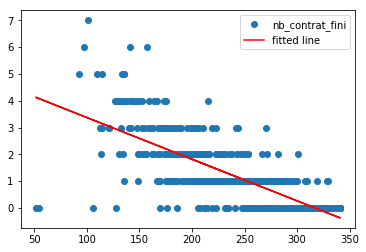

contrat_fini_max : non significatif

contrat_fini_min : slope:0.573760, intercept:-19.965651, 
	rvalue:0.511673, pvalue:0.000000, stderr:0.000000



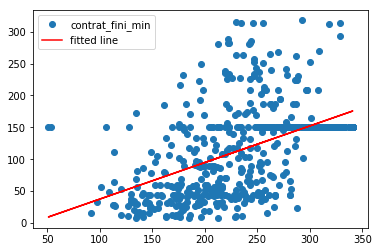

ancien_depute : slope:-0.000125, intercept:0.037044, 
	rvalue:-0.091566, pvalue:0.027315, stderr:0.027315



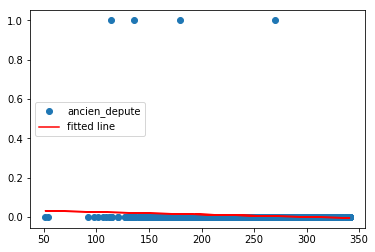

ratio_contrat_mandat : slope:0.002882, intercept:0.017930, 
	rvalue:0.561087, pvalue:0.000000, stderr:0.000000



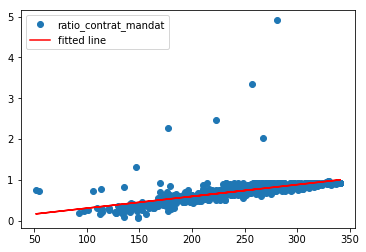

nb_mandats : non significatif

parlementaire_age : slope:0.024650, intercept:43.748358, 
	rvalue:0.134596, pvalue:0.001146, stderr:0.001146



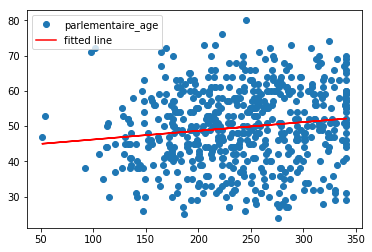

parlementaire_femme : slope:-0.001221, intercept:0.687105, 
	rvalue:-0.151506, pvalue:0.000247, stderr:0.000247



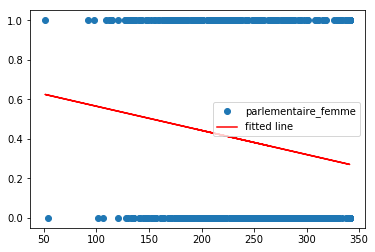

parlementaire_homme : slope:0.001221, intercept:0.312895, 
	rvalue:0.151506, pvalue:0.000247, stderr:0.000247



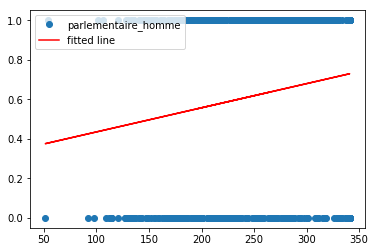

parlementaire_has_autre_mandats : non significatif

groupe_LR : non significatif

groupe_LREM : slope:-0.000620, intercept:0.689959, 
	rvalue:-0.075317, pvalue:0.069663, stderr:0.069663



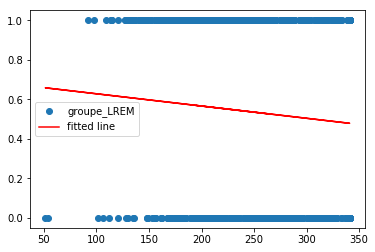

groupe_MODEM : non significatif

groupe_NG : slope:0.000284, intercept:-0.015053, 
	rvalue:0.076417, pvalue:0.065668, stderr:0.065668



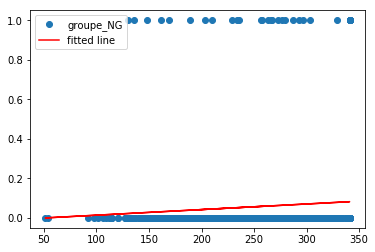

groupe_LFI : non significatif

groupe_UAI : non significatif

groupe_NI : slope:-0.000282, intercept:0.102363, 
	rvalue:-0.093554, pvalue:0.024126, stderr:0.024126



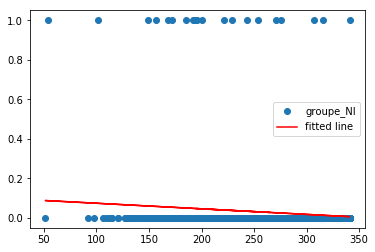

groupe_GDR : non significatif



In [393]:
tt = {}
for i in duree_tt.columns[4:].drop(["contrat_moyenne", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

# Tests statistiques sur les collaborateurs

In [396]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'ancien_depute', 'nb_mandats', 'parlementaire_age'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs.columns[41:]

Index(['contrat_fini', 'duree_mandat', 'parlementaire_age',
       'contrat_plus_de_2_mois', 'contrat_plus_de_4_mois',
       'contrat_plus_de_6_mois', 'contrat_mediane', 'contrat_moyenne',
       'nb_collaborateurs', 'contrat_max', 'contrat_min',
       'nb_contrats_plus_de_2_mois', 'ratio_plus_de_2_mois',
       'nb_contrats_plus_de_4_mois', 'ratio_plus_de_4_mois',
       'nb_contrats_plus_de_6_mois', 'ratio_plus_de_6_mois', 'nb_contrat_fini',
       'ratio_contrat_fini', 'contrat_fini_max', 'contrat_fini_min',
       'ratio_contrat_mandat', 'parlementaire_femme', 'parlementaire_homme',
       'parlementaire_has_autre_mandats', 'groupe_LR', 'groupe_LREM',
       'groupe_MODEM', 'groupe_NG', 'groupe_LFI', 'groupe_UAI', 'groupe_NI',
       'groupe_GDR', 'collaborateur_femme', 'collaborateur_homme'],
      dtype='object')

In [398]:
for i in tous_collaborateurs.columns[41:].drop(["duree_mandat", "parlementaire_age","contrat_mediane","contrat_moyenne","nb_collaborateurs","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

contrat_fini : -36.429239, 0.000000

contrat_plus_de_2_mois : 32.457215, 0.000000

contrat_plus_de_4_mois : 43.096841, 0.000000

contrat_plus_de_6_mois : 44.534727, 0.000000

parlementaire_femme : -5.294917, 0.000000

parlementaire_homme : 5.294917, 0.000000

parlementaire_has_autre_mandats non significatif

groupe_LR : 2.592166, 0.009588

groupe_LREM : -3.718160, 0.000205

groupe_MODEM non significatif

groupe_NG : 2.433758, 0.015007

groupe_LFI : 1.533775, 0.125201

groupe_UAI : 1.289669, 0.197275

groupe_NI : -1.957782, 0.050358

groupe_GDR non significatif

collaborateur_femme : 2.385169, 0.017139

collaborateur_homme : -2.385169, 0.017139



nb_mandats : non significatif

contrat_fini : slope:-0.002211, intercept:0.757117, 
	rvalue:-0.572848, pvalue:0.000000, stderr:0.000000



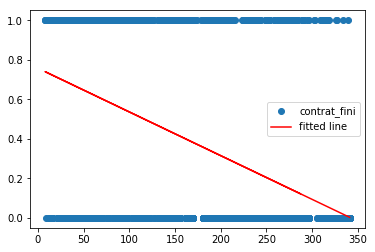

duree_mandat : slope:0.013096, intercept:365.202377, 
	rvalue:0.044110, pvalue:0.021442, stderr:0.021442



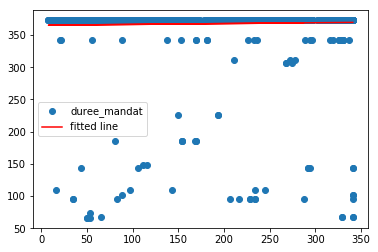

parlementaire_age : slope:0.007675, intercept:47.674550, 
	rvalue:0.078358, pvalue:0.000043, stderr:0.000043



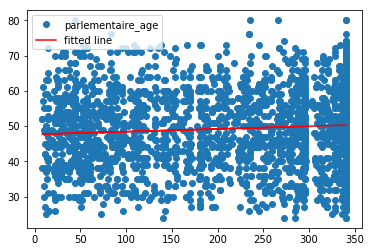

contrat_plus_de_2_mois : slope:0.001347, intercept:0.602061, 
	rvalue:0.528583, pvalue:0.000000, stderr:0.000000



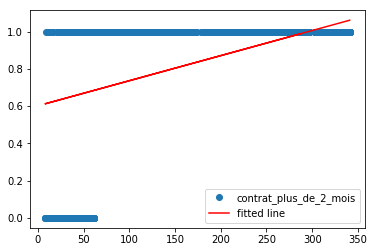

contrat_plus_de_4_mois : slope:0.002059, intercept:0.373051, 
	rvalue:0.637208, pvalue:0.000000, stderr:0.000000



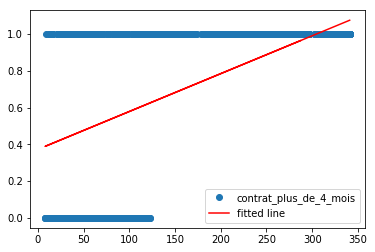

contrat_plus_de_6_mois : slope:0.002281, intercept:0.285420, 
	rvalue:0.649582, pvalue:0.000000, stderr:0.000000



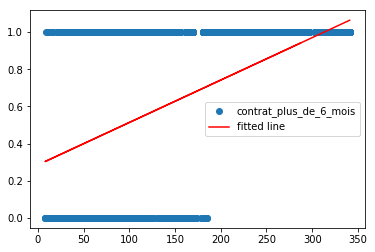

contrat_mediane : slope:0.344203, intercept:161.902408, 
	rvalue:0.480482, pvalue:0.000000, stderr:0.000000



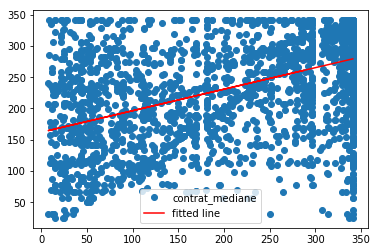

contrat_moyenne : slope:0.280708, intercept:164.440611, 
	rvalue:0.529819, pvalue:0.000000, stderr:0.000000



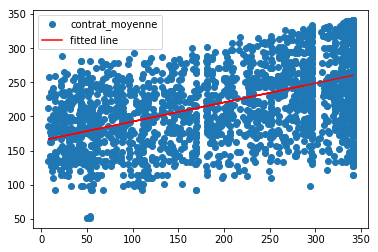

nb_collaborateurs : slope:-0.005072, intercept:6.378814, 
	rvalue:-0.339257, pvalue:0.000000, stderr:0.000000



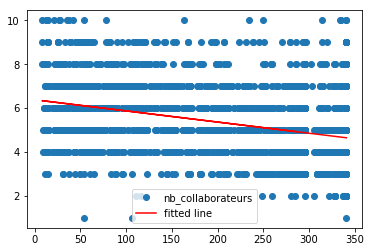

contrat_max : slope:0.061044, intercept:314.597679, 
	rvalue:0.223489, pvalue:0.000000, stderr:0.000000



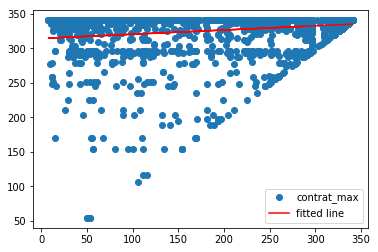

contrat_min : slope:0.367100, intercept:22.870388, 
	rvalue:0.427514, pvalue:0.000000, stderr:0.000000



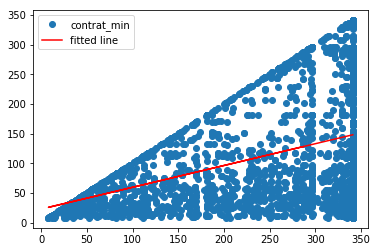

nb_contrats_plus_de_2_mois : slope:-0.004251, intercept:6.018170, 
	rvalue:-0.304705, pvalue:0.000000, stderr:0.000000



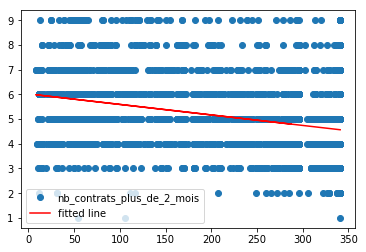

ratio_plus_de_2_mois : slope:0.000118, intercept:0.946162, 
	rvalue:0.190520, pvalue:0.000000, stderr:0.000000



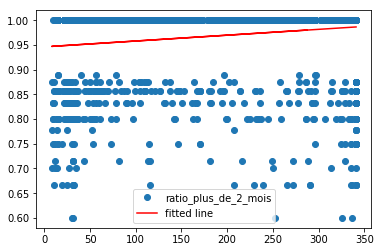

nb_contrats_plus_de_4_mois : slope:-0.002554, intercept:5.214321, 
	rvalue:-0.208827, pvalue:0.000000, stderr:0.000000



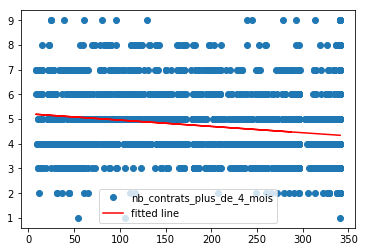

ratio_plus_de_4_mois : slope:0.000356, intercept:0.824025, 
	rvalue:0.305266, pvalue:0.000000, stderr:0.000000



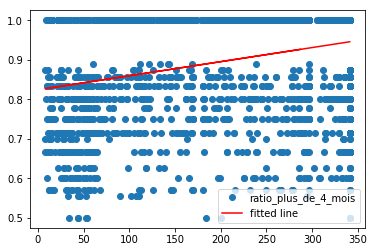

nb_contrats_plus_de_6_mois : slope:-0.001803, intercept:4.826678, 
	rvalue:-0.158737, pvalue:0.000000, stderr:0.000000



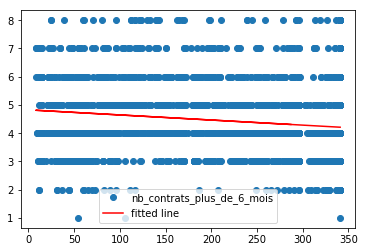

ratio_plus_de_6_mois : slope:0.000465, intercept:0.763189, 
	rvalue:0.347483, pvalue:0.000000, stderr:0.000000



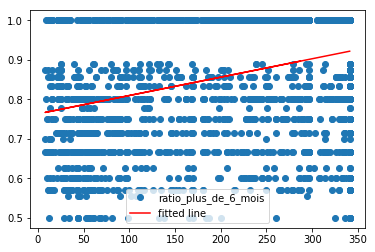

nb_contrat_fini : slope:-0.005104, intercept:2.664567, 
	rvalue:-0.414660, pvalue:0.000000, stderr:0.000000



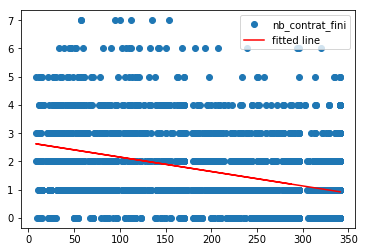

ratio_contrat_fini : slope:-0.000712, intercept:0.414281, 
	rvalue:-0.400373, pvalue:0.000000, stderr:0.000000



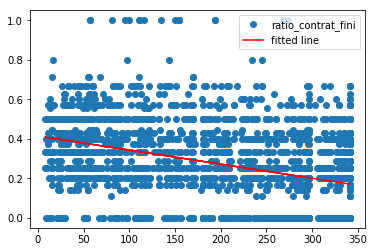

contrat_fini_max : non significatif

contrat_fini_min : slope:0.183271, intercept:66.648951, 
	rvalue:0.292163, pvalue:0.000000, stderr:0.000000



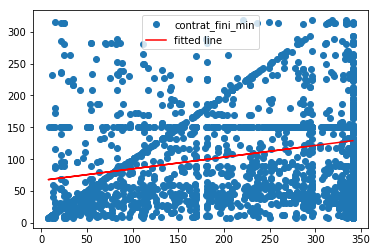

ratio_contrat_mandat : slope:0.000915, intercept:0.461408, 
	rvalue:0.319351, pvalue:0.000000, stderr:0.000000



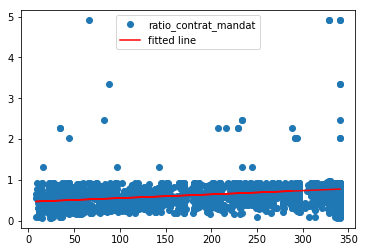

parlementaire_femme : slope:-0.000441, intercept:0.502766, 
	rvalue:-0.101061, pvalue:0.000000, stderr:0.000000



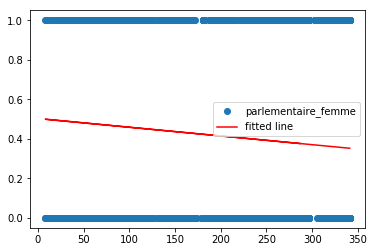

parlementaire_homme : slope:0.000441, intercept:0.497234, 
	rvalue:0.101061, pvalue:0.000000, stderr:0.000000



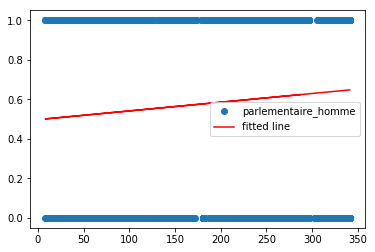

parlementaire_has_autre_mandats : non significatif

groupe_LR : slope:0.000170, intercept:0.141722, 
	rvalue:0.049669, pvalue:0.009588, stderr:0.009588



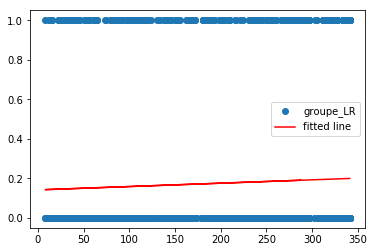

groupe_LREM : slope:-0.000315, intercept:0.617841, 
	rvalue:-0.071151, pvalue:0.000205, stderr:0.000205



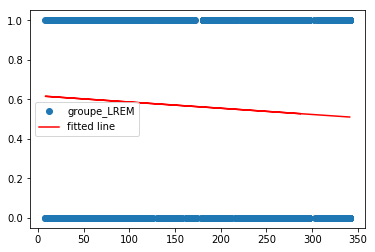

groupe_MODEM : non significatif

groupe_NG : slope:0.000089, intercept:0.027865, 
	rvalue:0.046640, pvalue:0.015007, stderr:0.015007



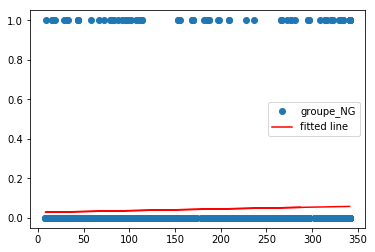

groupe_LFI : non significatif

groupe_UAI : non significatif

groupe_NI : slope:-0.000062, intercept:0.049834, 
	rvalue:-0.037533, pvalue:0.050358, stderr:0.050358



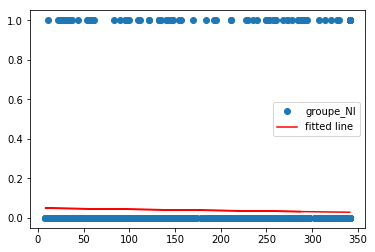

groupe_GDR : non significatif

collaborateur_femme : slope:0.000203, intercept:0.449654, 
	rvalue:0.045711, pvalue:0.017139, stderr:0.017139



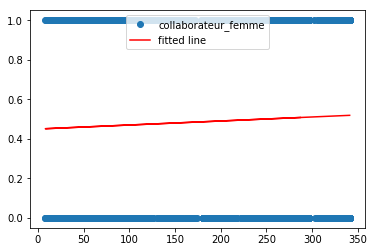

collaborateur_homme : slope:-0.000203, intercept:0.550346, 
	rvalue:-0.045711, pvalue:0.017139, stderr:0.017139



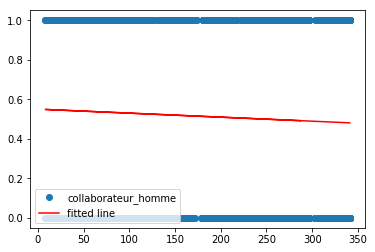

In [399]:
tt = {}
for i in tous_collaborateurs.drop(["nombredejours"], 1).columns[39:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")